In [1]:
import numpy as np
import scipy.io
import scipy.linalg
from scipy.linalg import fractional_matrix_power as matpow
from ssid import okid, ExtractModes
from control.matlab import * #need for "ss"
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 
from matplotlib import pyplot as plt


In [2]:
# Load data
p = 2   # Number of outputs
q = 2   # Number of inputs
n = 100 # State dimension (Number of structural dofs x 2)
r = 10  # Reduced model order ()
dt = 1  # Timestep
bruntondata = scipy.io.loadmat("./brunton_matlab/brunton_data.mat")
yImpulseFull = bruntondata['yFull']
yImpulse = bruntondata['YY']
uRandom = bruntondata['uRandom']
yRandom = bruntondata['yRandom']
print(yImpulse.shape)

(2, 2, 52)


In [3]:
# okid.okid(yRandom,uRandom,dt=1,kmax=200,orm=52,mro=100)

Dimensions
- p = Number of outputs (measured dof or ndof)
- q = Number of inputs (ngdof)
- n = State dimension (2ndof)
- r = Reduced model order (choose)

Full model
- Dimensions of $\mathbf{A}$: n x n
- Dimensions of $\mathbf{B}$: n x q
- Dimensions of $\mathbf{C}$: p x n
- Dimensions of $\mathbf{D}$: p x q

Reduced model
- Dimensions of $\mathbf{\tilde{A}}$: r x r
- Dimensions of $\mathbf{\tilde{B}}$: r x q
- Dimensions of $\mathbf{\tilde{C}}$: p x r
- Dimensions of $\mathbf{\tilde{D}}$: p x q

In [4]:
# example state evolution with unit impulse input

from sympy.matrices import Matrix, eye
B = Matrix(np.array([['a','b','c'],['d','e','f'],['g','h','i']]))
u1 = Matrix([1,0,0])
u2 = Matrix([0,1,0])
u3 = Matrix([0,0,1])
U = eye(3)

Bu1 = Matrix(B*u1).T
Bu2 = Matrix(B*u2).T
Bu3 = Matrix(B*u3).T

display("B = ", B)
display("U = ", U)
display("u1 = ", u1)
display("u2 = ", u2)
display("u3 = ", u3)
display("[Bu1, Bu2, Bu3] = ", Bu1.T.row_join(Bu2.T.row_join(Bu3.T)))
display("BU = ", B*U)

print("this illustrates that the desired impulse response (Y) is the matrix",
      "where each column corresponds to the column vector of output response (yi)",
      "corresponding to an input column vector where the ith element is one",
      "and all others are zero (ui).")

'B = '

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])

'U = '

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

'u1 = '

Matrix([
[1],
[0],
[0]])

'u2 = '

Matrix([
[0],
[1],
[0]])

'u3 = '

Matrix([
[0],
[0],
[1]])

'[Bu1, Bu2, Bu3] = '

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])

'BU = '

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])

this illustrates that the desired impulse response (Y) is the matrix where each column corresponds to the column vector of output response (yi) corresponding to an input column vector where the ith element is one and all others are zero (ui).


In [5]:
## Compute ERA from impulse response
mco = int(np.floor((yImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = okid.era(yImpulse,mco,mco,q,p,r)
sysERA = ss(Ar,Br,Cr,Dr,dt)

In [6]:
## Load impulse response data from hayward opensees
# exp = "changecol"
exp = "changedof"

input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
input21  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u1.txt")
output11 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output21 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")

input12  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u2.txt")
input22  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u2.txt")
output12 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output22 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")
nt = len(input11)
dt = 0.1


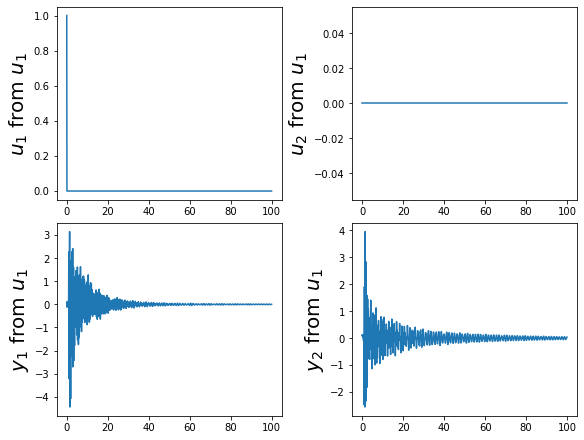

In [7]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input11)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input21)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{1}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output11)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output21)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20);

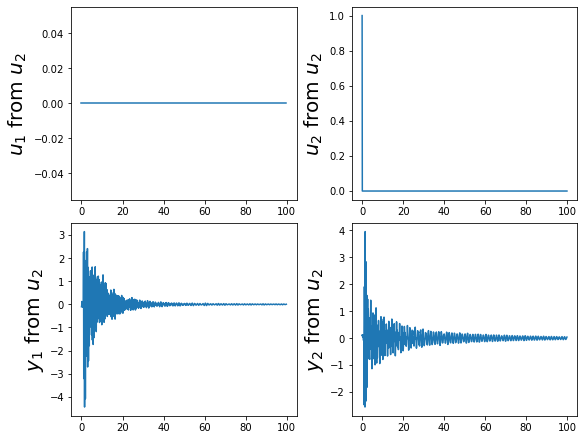

In [8]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input12)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{2}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input22)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{2}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output12)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output22)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20);

In [9]:
# Construct output data array
yOpsImpulse = np.array([[output11,output21],[output12,output22]])
print(yOpsImpulse.shape)

(2, 2, 1000)


In [10]:
## Compute ERA from impulse response
mco = int(np.floor((yOpsImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = okid.era(yOpsImpulse,mco,mco,q,p,20)
sysERA = ss(Ar,Br,Cr,Dr,dt)

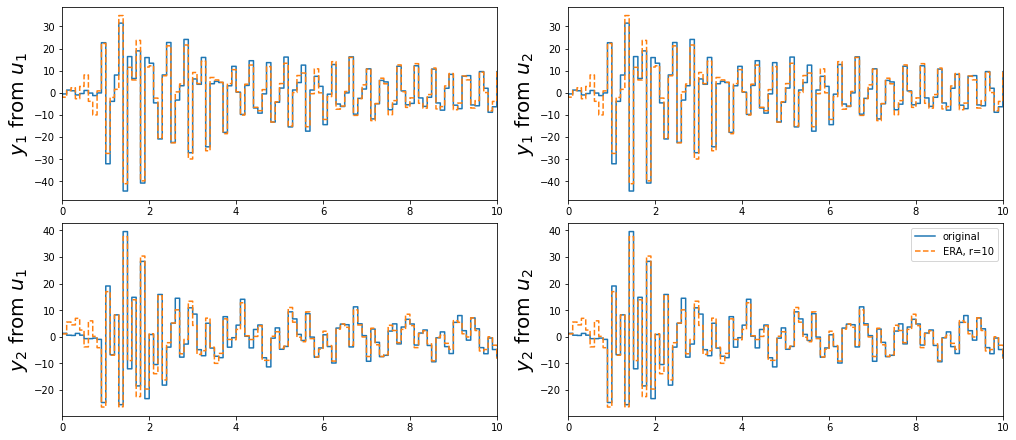

In [11]:
dt = 0.1
fig, ax = plt.subplots(2,2, figsize=(14,6), constrained_layout=True)
yERA = np.zeros((1000,p,q))
for i in range(q):
    yERA[:,:,i],times = impulse(sysERA,np.arange(start=0,stop=100,step=dt),input=i)

ax[0,0].step(times, output11/dt, label='original')
ax[0,0].step(times,yERA[:,0,0], '--')
ax[0,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].step(times, output12/dt, label='original')
ax[0,1].step(times,yERA[:,1,0], '--')
ax[0,1].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,0].step(times, output21/dt, label='original')
ax[1,0].step(times,yERA[:,0,1], '--')
ax[1,0].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20)
ax[1,1].step(times, output22/dt, label='original')
ax[1,1].step(times,yERA[:,1,1], '--', label=f'ERA, {r=}')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20)
ax[1,1].legend()
for axi in ax:
    for axj in axi:
        axj.set_xlim(0,10);

In [12]:
freqdmp, modeshape, _, _, _, = ExtractModes.ComposeModes(0.1, Ar, Br, Cr, Dr)
print('Periods:', [1/f for f in sorted(freqdmp[:,0])])

Periods: [1.2778208648188643, 0.998448914340318, 0.998448914340318, 0.9054698019860608, 0.9054698019860608, 0.46363230893932433, 0.46363230893932433, 0.3818231725946665, 0.3818231725946665, 0.36504522828142427, 0.36504522828142427, 0.3482361033585494, 0.3482361033585494, 0.22206141419812905, 0.22206141419812905, 0.21213792006033447, 0.21213792006033447, 0.2050917843853762]


In [13]:
modes = ExtractModes.modes(0.1, Ar, Cr)

print('Periods:', [1/f for f in sorted([modes[str(i)]['freq'] for i in range(10)])])

for i in range(3):
    print("Mode:", str(i))
    print("Condition Number:", modes[str(i)]['cnd'])
    print("Period:", 1/modes[str(i)]['freq'])
    print("Damping:", modes[str(i)]['damp'])
    print("Mode Shape:", modes[str(i)]['modeshape'])

Periods: [1.2778208648188643, 0.998448914340318, 0.9054698019860608, 0.46363230893932433, 0.3818231725946665, 0.36504522828142427, 0.3482361033585494, 0.22206141419812905, 0.21213792006033447, 0.2050917843853762]
Mode: 0
Condition Number: 346081649408776.3
Period: 1.2778208648188643
Damping: 0.004374923759568259
Mode Shape: [-0.34919621+0.23010014j -0.34919621+0.23010014j]
Mode: 1
Condition Number: 1125564512448157.1
Period: 0.9054698019860608
Damping: 0.0049629095167981205
Mode Shape: [-0.03121062-0.18364209j -0.03121062-0.18364209j]
Mode: 2
Condition Number: 1581384148121953.5
Period: 0.998448914340318
Damping: 0.006997538988231768
Mode Shape: [0.02440634-0.14234496j 0.02440634-0.14234496j]


In [ ]:
## Load impulse response data from hayward opensees
exp = "changecol"
# exp = "changedof"

input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
input21  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u1.txt")
output11 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output21 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")

input12  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u2.txt")
input22  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u2.txt")
output12 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output22 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")
nt = len(input11)
dt = 0.1


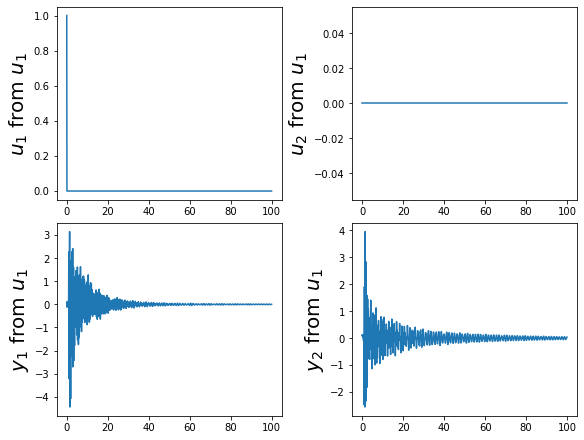

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input11)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input21)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{1}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output11)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output21)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20);

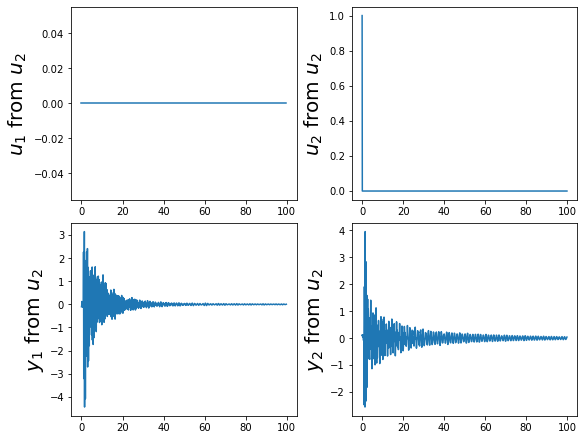

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input12)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{2}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input22)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{2}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output12)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output22)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20);

In [ ]:
# Construct output data array
yOpsImpulse = np.array([[output11,output21],[output12,output22]])
print(yOpsImpulse.shape)

(2, 2, 1000)


In [ ]:
## Compute ERA from impulse response
mco = int(np.floor((yOpsImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = okid.era(yOpsImpulse,mco,mco,q,p,20)
sysERA = ss(Ar,Br,Cr,Dr,dt)

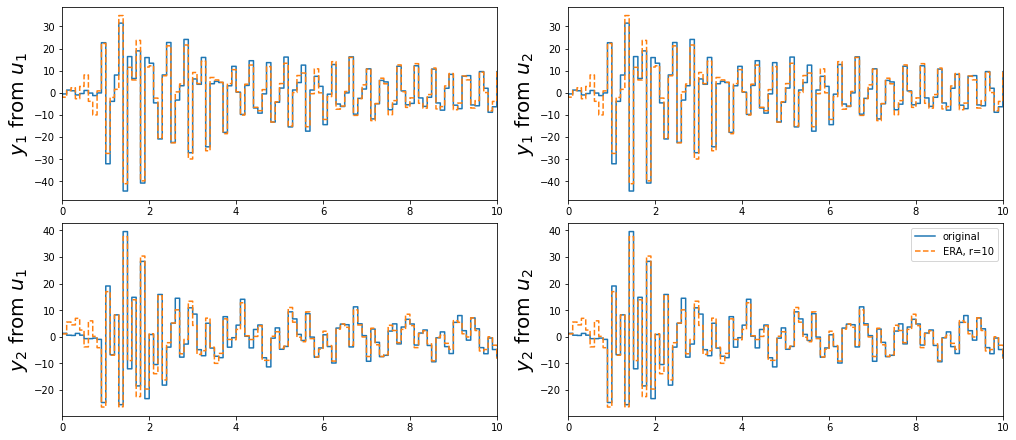

In [ ]:
dt = 0.1
fig, ax = plt.subplots(2,2, figsize=(14,6), constrained_layout=True)
yERA = np.zeros((1000,p,q))
for i in range(q):
    yERA[:,:,i],times = impulse(sysERA,np.arange(start=0,stop=100,step=dt),input=i)

ax[0,0].step(times, output11/dt, label='original')
ax[0,0].step(times,yERA[:,0,0], '--')
ax[0,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].step(times, output12/dt, label='original')
ax[0,1].step(times,yERA[:,1,0], '--')
ax[0,1].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,0].step(times, output21/dt, label='original')
ax[1,0].step(times,yERA[:,0,1], '--')
ax[1,0].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20)
ax[1,1].step(times, output22/dt, label='original')
ax[1,1].step(times,yERA[:,1,1], '--', label=f'ERA, {r=}')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20)
ax[1,1].legend()
for axi in ax:
    for axj in axi:
        axj.set_xlim(0,10);

In [ ]:
freqdmp, modeshape, _, _, _, = ExtractModes.ComposeModes(0.1, Ar, Br, Cr, Dr)
print('Periods:', [1/f for f in sorted(freqdmp[:,0])])

Periods: [1.2778208648188643, 0.998448914340318, 0.998448914340318, 0.9054698019860608, 0.9054698019860608, 0.46363230893932433, 0.46363230893932433, 0.3818231725946665, 0.3818231725946665, 0.36504522828142427, 0.36504522828142427, 0.3482361033585494, 0.3482361033585494, 0.22206141419812905, 0.22206141419812905, 0.21213792006033447, 0.21213792006033447, 0.2050917843853762]


In [ ]:
modes = ExtractModes.modes(0.1, Ar, Cr)

print('Periods:', [1/f for f in sorted([modes[str(i)]['freq'] for i in range(10)])])

for i in range(3):
    print("Mode:", str(i))
    print("Condition Number:", modes[str(i)]['cnd'])
    print("Period:", 1/modes[str(i)]['freq'])
    print("Damping:", modes[str(i)]['damp'])
    print("Mode Shape:", modes[str(i)]['modeshape'])

Periods: [1.2778208648188643, 0.998448914340318, 0.9054698019860608, 0.46363230893932433, 0.3818231725946665, 0.36504522828142427, 0.3482361033585494, 0.22206141419812905, 0.21213792006033447, 0.2050917843853762]
Mode: 0
Condition Number: 346081649408776.3
Period: 1.2778208648188643
Damping: 0.004374923759568259
Mode Shape: [-0.34919621+0.23010014j -0.34919621+0.23010014j]
Mode: 1
Condition Number: 1125564512448157.1
Period: 0.9054698019860608
Damping: 0.0049629095167981205
Mode Shape: [-0.03121062-0.18364209j -0.03121062-0.18364209j]
Mode: 2
Condition Number: 1581384148121953.5
Period: 0.998448914340318
Damping: 0.006997538988231768
Mode Shape: [0.02440634-0.14234496j 0.02440634-0.14234496j]
